<a href="https://colab.research.google.com/github/MaxWutw/Deep-Learning/blob/main/Cat_and_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision.datasets import DatasetFolder
from torchsummary import summary
from tqdm import tqdm_notebook as tqdm

In [6]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')

CUDA is available!


In [7]:
%cd cat_train

[Errno 2] No such file or directory: 'cat_train'
/content/drive/MyDrive/Colab Notebooks


In [8]:
!ls

 CNN_live					    'RNN 做情意分析'
 「colab03RNN做情意分析.ipynb」的副本		     test
'colab04b 用transformer快速打造文字生成器.ipynb'     toonify.ipynb
'「colab99 在 matplotlib 中使用中文.ipynb」的副本'   train
' Cooper 真的是馬爾濟斯嗎.ipynb'		     Untitled
 flagged					     Untitled0.ipynb
'Gradio2 快速 NLP.ipynb'			     Untitled1.ipynb
 gradio_mnist					     「Untitled1.ipynb」的副本
 HW1.ipynb					     Untitled2.ipynb
 「Live.ipynb」的副本				     validation
 live_model.h5					     使用紅樓夢生成器
'matplotlib 中使用中文.ipynb」的副本'		    ' 打造自己的 tokenizer'
'MNIST live'					     用遷移學習打造八哥辨識AI
 model_cat_dog.pth


In [9]:
train_path = '/content/drive/MyDrive/Colab Notebooks/train/'
val_path = '/content/drive/MyDrive/Colab Notebooks/validation/'
test_path = '/content/drive/MyDrive/Colab Notebooks/test'

In [10]:
# transforms = torch.nn.Sequential(
#     transforms.CenterCrop(10),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# )
# scripted_transforms = torch.jit.script(transforms)
# I don't know how to set normalize value, so I copy pytorch documents sample code.
# min max normalization
# train_trans = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# val_trans = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# test_trans = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
## cat 0
## dog 1
### Data Augmentation
train_trans = transforms.Compose(
    [transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation((-30, 30)),
     transforms.Resize((224, 224)), 
     transforms.ToTensor(), 
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_trans = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_trans = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


In [11]:
batch_size = 32

# train_data = DatasetFolder(train_path, loader = lambda i: Image.open(i), extensions = "jpg", transform = train_trans)
# val_data = DatasetFolder(val_path, loader = lambda i: Image.open(i), extensions = "jpg", transform = test_trans)
# test_data = DatasetFolder(test_path, loader = lambda i: Image.open(i), extensions = "jpg", transform = test_trans)
# img = Image.open(train_path + "/cat_train/cat.1044.jpg")

train_data = ImageFolder(train_path, transform = train_trans)
val_data = ImageFolder(val_path,transform = test_trans)
test_data = ImageFolder(test_path, transform = test_trans)

# shuffle: Each epoch's training sample are different
# drop_last: If the dataset can't be divided by the batch_size, the last data won't be remove
# num_workers: num_workers is depend on your cpu and your RAM, and num_workers can help you preload the batch data and store in RAM,
# if you have lots of num_workers, your preload speed will be fast, but in the other hand, your cpu will have increasing burden
# pin_memory: If this parameter is True, Dataloader will copy the tensor to CUDA's RAM, before return
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True, num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)
print(train_loader)

In [12]:
print(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


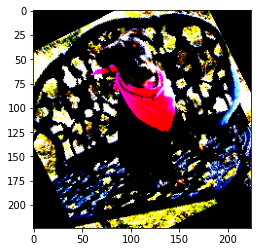

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


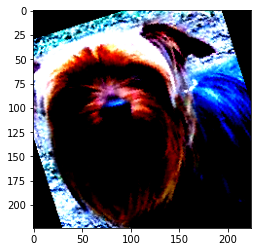

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


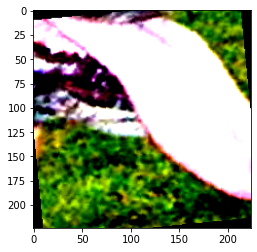

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


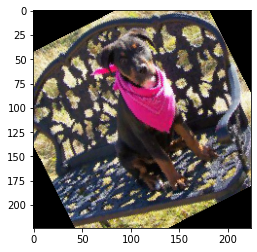

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


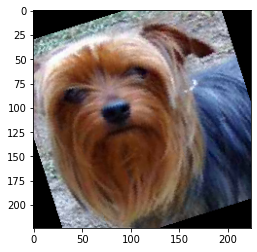

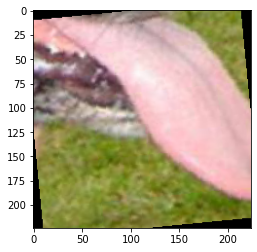

In [13]:
images, labels = next(iter(train_loader))
# After Normalize
for i in np.arange(3):
  plt.figure(i)
  plt.imshow(images[i].permute(1, 2, 0))
  plt.show()
# Before Normalize
for i in np.arange(3):
  plt.figure(i)
  # Our data are normalized, in order to watch our origin image, so we need to denormalize our data
  mean = torch.tensor([0.485, 0.456, 0.406])
  std = torch.tensor([0.229, 0.224, 0.225])
  tmp = transforms.Normalize(-mean/std, 1/std)(images[i]) # denormalize
  plt.imshow(tmp.permute(1, 2, 0)) # The data in pytorch is (channel, size, size), and we need to change it to (size, size, channel)
  plt.show()

In [14]:
# 1. Input layer
# 2. Convolutional layer
# 3. ReLU layer
# 4. Pooling layer
# 5. Fully-connected layer
class Cat_Dog(nn.Module):
  def __init__(self):
    super(Cat_Dog, self).__init__()
    # input_shape = (3, 224, 224)
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
    #                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    # in_channels: Input channels
    # out_channels: Output channels
    # kernel_size: Fillter size
    # stride: Each step our Fillter move
    # padding: We want our image can remain origin size
    self.cnn = nn.Sequential(
        ## CNN1
        nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1), # padding = kernel_size / 2
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (64, 112, 112)
        ## CNN2
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (128, 56, 56)
        ## CNN3
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (256, 28, 28)
        ## CNN4
        nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (512, 14, 14)
        ## CNN5
        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)## (512, 7, 7)
    )
    self.fc = nn.Sequential(
        nn.Linear(512 * 7 * 7, 300), # Fully-connected layer
        nn.Dropout(0.25), # Avoid overfitting
        nn.ReLU(),
        nn.Linear(300, 300),
        nn.Dropout(0.25),
        nn.ReLU(),
        nn.Linear(300, 2),
        # nn.Softmax(dim = 1) # To make our answer's probability sum equal one
        nn.Sigmoid()
    )
  # forward propagation
  def forward(self, x):
    x = self.cnn(x)
    x = x.flatten(1)
    x = self.fc(x)
    return x

In [15]:
device = "cuda" if train_on_gpu else "cpu"
model = Cat_Dog()
model = model.to(device)
print(model)

Cat_Dog(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=25088, out_features=300, bias=Tr

In [16]:
len(train_loader.dataset)

3950

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
loss_func = nn.CrossEntropyLoss()

n_epochs = 30
train_loss_record = []
train_acc_record = []
val_loss_record = []
val_acc_record = []
# print(train_loader)
# print(model(train_loader[1]))
for epoch in range(n_epochs):
  train_loss = 0.0
  val_loss = 0.0
  train_acc = 0.0
  val_acc = 0.0
  model.train()

  for i, j in tqdm(train_loader):
    optimizer.zero_grad()
    i, j = i.to(device), j.to(device)
    prediction = model(i)
    loss = loss_func(prediction, j)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*i.size(0)
    pred = torch.argmax(prediction, dim=1)
    correct = pred.eq(j)
    train_acc = torch.mean(correct.float())

  model.eval()
  train_loss = train_loss/len(train_loader.dataset)
  print(f"[ Train | {epoch+1}/{n_epochs} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
  train_loss_record.append(train_loss)
  train_acc_record.append(train_acc)

  for i, j in tqdm(val_loader):
    optimizer.zero_grad()
    i, j = i.to(device), j.to(device)
    prediction = model(i)
    loss = loss_func(prediction, j)
    loss.backward()
    optimizer.step()
    val_loss += loss.item()*i.size(0)
    pred = torch.argmax(prediction, dim=1)
    correct = pred.eq(j)
    val_acc = torch.mean(correct.float())
    
  val_loss = val_loss/len(val_loader.dataset)
  print(f"[ Validation | {epoch+1}/{n_epochs} ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")
  val_loss_record.append(val_loss)
  val_acc_record.append(val_acc)
torch.save(model, 'cat_dog.pth')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



[ Train | 1/30 ] loss = 0.81966, acc = 0.50000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



[ Validation | 1/30 ] loss = 0.81364, acc = 0.50000



[ Train | 2/30 ] loss = 0.81963, acc = 0.28571



[ Validation | 2/30 ] loss = 0.81364, acc = 0.00000



[ Train | 3/30 ] loss = 0.81951, acc = 0.35714



[ Validation | 3/30 ] loss = 0.81364, acc = 0.37500



[ Train | 4/30 ] loss = 0.81941, acc = 0.64286



[ Validation | 4/30 ] loss = 0.81364, acc = 0.12500



[ Train | 5/30 ] loss = 0.81913, acc = 0.50000



[ Validation | 5/30 ] loss = 0.81364, acc = 0.50000



[ Train | 6/30 ] loss = 0.81950, acc = 0.57143



[ Validation | 6/30 ] loss = 0.81364, acc = 0.62500



[ Train | 7/30 ] loss = 0.81935, acc = 0.42857



[ Validation | 7/30 ] loss = 0.81364, acc = 0.62500



[ Train | 8/30 ] loss = 0.82005, acc = 0.71429



[ Validation | 8/30 ] loss = 0.81364, acc = 0.37500



[ Train | 9/30 ] loss = 0.81929, acc = 0.50000



[ Validation | 9/30 ] loss = 0.81364, acc = 0.62500



[ Train | 10/30 ] loss = 0.81943, acc = 0.57143



[ Validation | 10/30 ] loss = 0.81364, acc = 0.25000



[ Train | 11/30 ] loss = 0.81922, acc = 0.42857



[ Validation | 11/30 ] loss = 0.81364, acc = 0.37500



[ Train | 12/30 ] loss = 0.81906, acc = 0.50000



[ Validation | 12/30 ] loss = 0.81326, acc = 0.62500



[ Train | 13/30 ] loss = 0.81959, acc = 0.57143



[ Validation | 13/30 ] loss = 0.81326, acc = 0.62500



[ Train | 14/30 ] loss = 0.81959, acc = 0.50000



[ Validation | 14/30 ] loss = 0.81326, acc = 0.25000



[ Train | 15/30 ] loss = 0.81959, acc = 0.64286



[ Validation | 15/30 ] loss = 0.81326, acc = 0.75000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34e17a320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34e17a320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


[ Train | 16/30 ] loss = 0.81959, acc = 0.57143


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34e17a320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34e17a320>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


[ Validation | 16/30 ] loss = 0.81326, acc = 0.37500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34e17a320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34e17a320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


[ Train | 17/30 ] loss = 0.81959, acc = 0.50000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34e17a320>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34e17a320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in


[ Validation | 17/30 ] loss = 0.81326, acc = 0.62500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34e17a320>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34e17a320>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in


[ Train | 18/30 ] loss = 0.81959, acc = 0.42857



[ Validation | 18/30 ] loss = 0.81326, acc = 0.25000



[ Train | 19/30 ] loss = 0.81959, acc = 0.64286



[ Validation | 19/30 ] loss = 0.81326, acc = 0.25000



[ Train | 20/30 ] loss = 0.81959, acc = 0.64286



[ Validation | 20/30 ] loss = 0.81326, acc = 0.62500



[ Train | 21/30 ] loss = 0.81959, acc = 0.28571



[ Validation | 21/30 ] loss = 0.81326, acc = 0.37500



[ Train | 22/30 ] loss = 0.81959, acc = 0.50000



[ Validation | 22/30 ] loss = 0.81326, acc = 0.50000



[ Train | 23/30 ] loss = 0.81959, acc = 0.57143



[ Validation | 23/30 ] loss = 0.81326, acc = 0.62500



[ Train | 24/30 ] loss = 0.81959, acc = 0.57143



[ Validation | 24/30 ] loss = 0.81326, acc = 0.62500



[ Train | 25/30 ] loss = 0.81959, acc = 0.42857



[ Validation | 25/30 ] loss = 0.81326, acc = 0.62500



[ Train | 26/30 ] loss = 0.81959, acc = 0.71429



[ Validation | 26/30 ] loss = 0.81326, acc = 0.75000



[ Train | 27/30 ] loss = 0.81959, acc = 0.64286



[ Validation | 27/30 ] loss = 0.81326, acc = 0.37500



[ Train | 28/30 ] loss = 0.81959, acc = 0.42857



[ Validation | 28/30 ] loss = 0.81326, acc = 0.25000



[ Train | 29/30 ] loss = 0.81959, acc = 0.57143



[ Validation | 29/30 ] loss = 0.81326, acc = 0.25000



[ Train | 30/30 ] loss = 0.81959, acc = 0.64286



[ Validation | 30/30 ] loss = 0.81326, acc = 0.50000


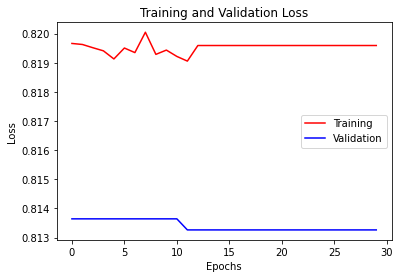

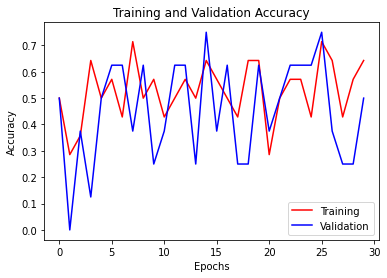

In [32]:
plt.figure(1)
plt.title('Training and Validation Loss')
train_l, = plt.plot(train_loss_record, color = 'red')
val_l, = plt.plot(val_loss_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(handles = [train_l, val_l], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

plt.figure(2)
plt.title('Training and Validation Accuracy')
train_a, = plt.plot(train_acc_record, color = 'red')
val_a, = plt.plot(val_acc_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(handles = [train_a, val_a], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

In [37]:
device = "cuda" if train_on_gpu else "cpu"
loss_func = nn.CrossEntropyLoss()
test_loss = 0.0
correct = 0.0
model = torch.load('/content/drive/MyDrive/Colab Notebooks/cat_dog.pth')
model = model.to(device)
model.eval()
# for idx, (data, target) in enumerate(test_loader):
#   if train_on_gpu:
#     data, target = data.cuda(), target.cuda()
#   pred = model(data)
#   loss = loss_func(pred, target)
#   test_loss = test_loss + ((1 / idx+1) * (loss.data - test_loss))
for data, target in tqdm(test_loader):
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  prediction = model(data)
  loss = loss_func(prediction, target)
  pred = torch.argmax(prediction, dim=1)
  correct = pred.eq(target)
  test_acc = torch.mean(correct.float())
print(f"{test_acc:.5f}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



1.00000
